# Calibration of SGLD hyperparameters for MNIST

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/sgld_calibration.ipynb)

This notebook walks through the process for calibrating hyperparameters for Stochastic Gradient Langevin Dynamics (SGLD) based LLC (or $\hat\lambda$) estimation. The model we'll use is a small 2-layer ReLU network (~1M params) trained on the MNIST dataset.

This notebook is split into 5 sections:
1. Data preparation
2. Training model checkpoints
3. Running calibration sweep
4. Plotting LLC estimations over time
5. Selecting $\epsilon$ and $\gamma$

In [2]:
%pip install devinterp torchvision

INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 3.9 MB/s eta 0:00:0011.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [54]:
import copy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

from devinterp.optim.sgld import SGLD
from devinterp.slt.llc import estimate_learning_coeff_with_summary

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NUM_CHAINS = 10
NUM_DRAWS = 200

plt.rcParams["figure.figsize"]=12,9  # note: this cell may need to be re-run after creating a plot to take effect

In [20]:
# Define the neural network
class MNIST(nn.Module):
    def __init__(
        self,
        hidden_layer_sizes=[1024, 1024],
        input_dim=28 * 28,
        output_dim=10,
        activation=F.relu,
        with_bias=True,
    ):
        super(MNIST, self).__init__()
        self.input_dim = input_dim
        self.layer_sizes = [input_dim] + hidden_layer_sizes + [output_dim]
        self.activation = activation
        self.with_bias = with_bias
        self.layers = nn.ModuleList()
        for i in range(len(self.layer_sizes) - 1):
            dim_in, dim_out = self.layer_sizes[i : i + 2]
            self.layers.append(nn.Linear(dim_in, dim_out, bias=self.with_bias).float())

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

# Train/test utils
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)


def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    return test_loss / len(test_loader)

### 1. Data preparation

In [21]:
# Load MNIST data
batch_size = 512
train_data = datasets.MNIST("../data", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
print(len(train_data))
# Load test data
test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
# Initialize model, loss, optimizer and sgld sampler
model = MNIST().to(DEVICE)
criterion = nn.CrossEntropyLoss()
lr = 0.005
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
n_epochs = 20

60000


### 2. Training model checkpoints

In [9]:
# train model
train_losses = []
test_losses = []
rlct_estimates = []
checkpoints = []
for epoch in range(n_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    test_loss = evaluate(model, test_loader, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    checkpoints += [copy.deepcopy(model)]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}")

100%|██████████| 118/118 [00:02<00:00, 43.88it/s]


Epoch 1, Train Loss: 1.9797865556458296, Test Loss: 1.2560135543346405


100%|██████████| 118/118 [00:02<00:00, 46.78it/s]


Epoch 2, Train Loss: 0.770378463601662, Test Loss: 0.5147849828004837


100%|██████████| 118/118 [00:02<00:00, 47.04it/s]


Epoch 3, Train Loss: 0.4573417854006008, Test Loss: 0.3940457791090012


100%|██████████| 118/118 [00:02<00:00, 47.11it/s]


Epoch 4, Train Loss: 0.38147303057929216, Test Loss: 0.34821412712335587


100%|██████████| 118/118 [00:02<00:00, 47.47it/s]


Epoch 5, Train Loss: 0.34229465498257494, Test Loss: 0.31924872323870657


100%|██████████| 118/118 [00:02<00:00, 46.97it/s]


Epoch 6, Train Loss: 0.31893183770826306, Test Loss: 0.3017466992139816


100%|██████████| 118/118 [00:02<00:00, 47.92it/s]


Epoch 7, Train Loss: 0.3005186294094991, Test Loss: 0.2882169097661972


100%|██████████| 118/118 [00:02<00:00, 47.71it/s]


Epoch 8, Train Loss: 0.2862948258802042, Test Loss: 0.27552246041595935


100%|██████████| 118/118 [00:02<00:00, 47.75it/s]


Epoch 9, Train Loss: 0.27352688764616595, Test Loss: 0.2621148329228163


100%|██████████| 118/118 [00:02<00:00, 47.68it/s]


Epoch 10, Train Loss: 0.26054534631765497, Test Loss: 0.2515824556350708


100%|██████████| 118/118 [00:02<00:00, 47.87it/s]


Epoch 11, Train Loss: 0.24949417945186972, Test Loss: 0.24301711581647395


100%|██████████| 118/118 [00:02<00:00, 45.39it/s]


Epoch 12, Train Loss: 0.24039886108899522, Test Loss: 0.23471374846994877


100%|██████████| 118/118 [00:02<00:00, 48.18it/s]


Epoch 13, Train Loss: 0.230219757152816, Test Loss: 0.2255936823785305


100%|██████████| 118/118 [00:02<00:00, 47.80it/s]


Epoch 14, Train Loss: 0.22106221659203706, Test Loss: 0.21661872491240503


100%|██████████| 118/118 [00:02<00:00, 47.60it/s]


Epoch 15, Train Loss: 0.21126644338591624, Test Loss: 0.21106843762099742


100%|██████████| 118/118 [00:02<00:00, 46.75it/s]


Epoch 16, Train Loss: 0.20343748959949462, Test Loss: 0.2032333232462406


100%|██████████| 118/118 [00:02<00:00, 47.63it/s]


Epoch 17, Train Loss: 0.19644407347097234, Test Loss: 0.1954937607049942


100%|██████████| 118/118 [00:02<00:00, 48.54it/s]


Epoch 18, Train Loss: 0.18864557020745035, Test Loss: 0.18853942342102528


100%|██████████| 118/118 [00:02<00:00, 48.22it/s]


Epoch 19, Train Loss: 0.18161925534575674, Test Loss: 0.1833230372518301


100%|██████████| 118/118 [00:02<00:00, 48.75it/s]


Epoch 20, Train Loss: 0.1746838912999226, Test Loss: 0.17762466333806515


### 3. Running calibration sweep

The main idea is to sweep across orders of magnitude of learning rate (epsilon) and elasticity (gamma). We look at the mean of LLC estimations over time by looking at the average estimated LLC for each chain at a given time step.

In [35]:
epsilons = [1e-5, 1e-4]
gammas = [1, 10]

# LLC estimation for fixed eps, gamma
def estimate_llc_helper(model, eps, gamma):
    optim_kwargs = dict(
        lr=eps,
        noise_level=1.0,
        elasticity=gamma,
        num_samples=len(train_data),
        temperature="adaptive",
    )
    results = estimate_learning_coeff_with_summary(
        model=model,
        loader=train_loader,
        criterion=criterion,
        sampling_method=SGLD,
        optimizer_kwargs=optim_kwargs,
        num_chains=NUM_CHAINS,
        num_draws=NUM_DRAWS,
        device=DEVICE,
        online=True,
    )
    return results['llc/means']

In [58]:
num_training_samples = [int(6e5), int(1.2e6)]
llc_means = {}

for samples in num_training_samples:
    for epsilon in epsilons:
        for gamma in gammas:
            pair = (samples, epsilon, gamma)
            means = estimate_llc_helper(checkpoints[-1], epsilon, gamma)
            llc_means[pair] = means

Chain 9: 100%|██████████| 200/200 [00:07<00:00, 26.20it/s]


### 4. Plotting LLC estimations over time

In [73]:
import matplotlib.pyplot as plt

def plot_sweep(llc_means, checkpoint_steps, epsilons, gammas):
    fig, axs = plt.subplots(len(epsilons), len(gammas))
    for i, epsilon in enumerate(epsilons):
        for j, gamma in enumerate(gammas):
            for steps in checkpoint_steps:
                means = llc_means[(steps, epsilon, gamma)]
                sgld_steps = list(range(len(means)))
                axs[i, j].plot(sgld_steps, means, label=f'{steps} training steps')
            axs[i, j].set_title(f"$\epsilon$ = {epsilon}, $\gamma$ = {gamma}")
            axs[i, j].legend()
    fig.suptitle('Calibration sweep of MNIST model for $\epsilon$ and $\gamma$', fontsize=16)
    plt.tight_layout()
    plt.show()

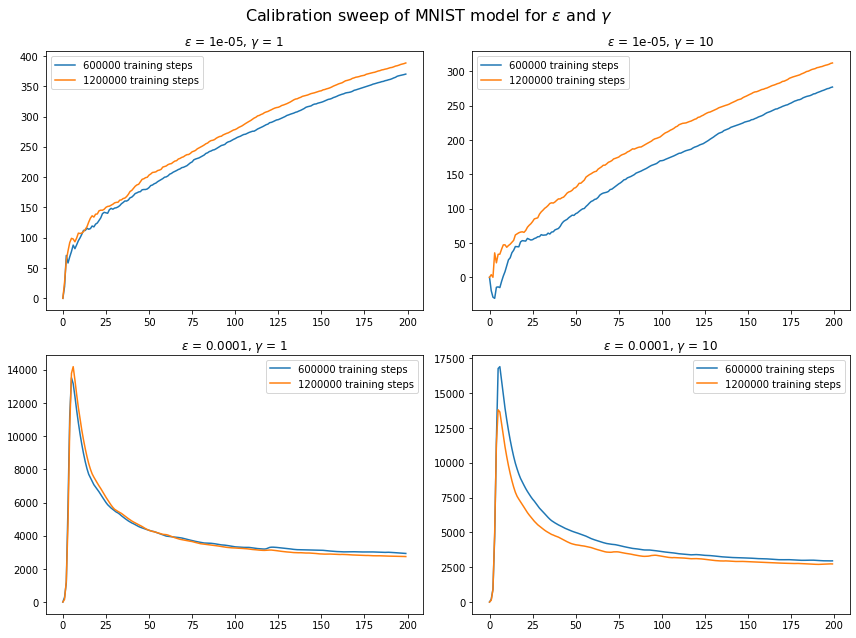

In [74]:
plot_sweep(llc_means, num_training_samples, epsilons, gammas)

### 5. Selecting $\epsilon$ and $\gamma$

There is currently no One True Set of hyperparameters. Instead, the goal of calibration is to identify hyperparameters that maintain certain desirable properties. Some general such heuristics:
- Optimal traces should converge.
- Absolute $\hat\lambda$ estimates are not as important as relative $\hat\lambda$ estimates.
- The most important feature is that the relative ordering of estimates is maintained if you have different models to compare (e.g. different checkpoints).
- The graph should not have negative dips (or not dip negative for very long).
- You can also examine the loss traces or other diagnostics to check that they look healthy (see the Diagnostics demo [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/diagnostics.ipynb) for examples and other diagnostic tools)
  - A good set of loss traces should stay above the initial loss value (or at least not drop below it too far or for too many steps) and should not diverge away from the initial loss value.

In the above example, we chose a smaller set of epsilons and gammas in order to reduce the time needed to run the notebook. A typical starting point might be `epsilons = [1e-5, 1e-4, 1e-3]` and `gammas = [1, 10, 100]`, and if you don't get good results on the first sweep, you might recenter your sweep and try again.

**Comments on this particular example**
- The top two graphs don't appear to converge within the 200 draw steps.
  - (200 also isn't a *lot*, you may want to run your sweeps with more than 200 draw steps)
- The top right graph has a small negative dip, but that isn't too concerning.
- The bottom left graph has lines that appear to cross, but the lines are pretty close to overlapping.
- The bottom two graphs do appear to converge, and either one might be fine for parameter selection, but it may also be worth running a new sweep with higher learning rate.